<a href="https://colab.research.google.com/github/pgallardo/Analysis_GIT_data/blob/master/WagnerStrategy_Patricio_Feb24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install sympy==1.12.0

In [2]:

#cProfile.run('your_function_call()')  # Replace with your function call

In [3]:
#!pip install optuna==3.3.0

In [4]:
#!pip install line_profiler==3.1.0

In [5]:
#!pip install --upgrade scipy

In [6]:
#!pip install mpmath>=1.3.0

In [7]:
#!pip install --upgrade scipy

In [8]:
import math
import random
import gym
import numpy as np
from   shapely.geometry import Polygon, Point, LineString
import sympy

from gym import spaces
from stable_baselines3 import PPO
from sympy import symbols, Eq, nsolve, diff, solveset, S, sqrt, isprime, factor, Poly, SympifyError, Add

from fractions import Fraction

import matplotlib.pyplot as plt

import torch.nn as nn
import torch
import torch.optim as optim

import time
import timeit

import scipy
from scipy.special import binom # Import binom function
import scipy.linalg
# Set high precision for AFRP fallback
import mpmath
mpmath.mp.dps = 100  # Use 100-digit precision for stability

from functools import partial
import multiprocessing
from multiprocessing import Manager

In [9]:
#All parameters

#size of the box
max_a = 5 # Upper limit for a
max_b = 20 # Upper limit for b
max_c = 20 # #Upper limit for c

solutions = set()

n_generations = 300 # number_generations

# NN parameters
learning_rate = 4.782414136447625e-05
n_layers_NN = 4
n_units_NN = 58

# Game parameters

number_agents_session = 100    # How many parallel searches per generation
max_number_steps = 20  # Max step per session -> modifications_per_session
elite_percentile = 78
super_elite_percentage = 96

# Parameters for the reward function
bonus             = 1.7445851992715213
scaling           = 0.4064981769195448
weight_distances  = 0.1704666782187617
w1                = 0.6471859193374961
w2                = 0.4415219203321601


In [10]:
"""
The following functions calculate relevant numbers from the polygons and will be used later.
"""

def find_lattice_points(vertices):
  """
  vertices has the format [(0, 0), (1, 0), (1, 1), (0, 1)]
  """
  polygon = Polygon(vertices)
  min_x, min_y, max_x, max_y = polygon.bounds

  #find lattice polytopes in the polygon
  lattice_points = []
  for x in range(int(min_x), int(max_x) + 1):
      for y in range(int(min_y), int(max_y) + 1):
          point = Point(x, y)
          if polygon.intersects(point):
            lattice_points.append( (int(point.x), int(point.y)) )

  return lattice_points


def count_boundary_lattice_points(vertices):
  """
  Counts the number of lattice points on the boundary of a polygon.

  Args:
      vertices: A list of tuples representing the polygon vertices [(x1, y1), (x2, y2),...].

  Returns:
      The number of lattice points on the boundary.
  """
  polygon = Polygon(vertices)
  unique_points = set()  # Use a set for efficient checking

  for i in range(len(vertices)):
      x1, y1 = vertices[i]
      x2, y2 = vertices[(i + 1) % len(vertices)]  # Wrap around

      line = LineString([(x1, y1), (x2, y2)])

      min_x = min(x1, x2)
      max_x = max(x1, x2)
      min_y = min(y1, y2)
      max_y = max(y1, y2)
      for x in range(int(min_x), int(max_x) + 1):
          for y in range(int(min_y), int(max_y) + 1):
              point = Point(x, y)
              if line.intersects(point) and polygon.touches(point):
                  unique_points.add((x, y))  # Add to the set

  return len(unique_points)

def compute_boundary_and_area(vertices):
  """
  vertices is a list of tuples (x,y)
  Calculates twice the area of a polygon, and the number of points
  in the boundary.
  """
  polygon = Polygon(vertices)
  twice_area = int(2*polygon.area)
  boundary_points  = count_boundary_lattice_points(vertices)

  return twice_area, boundary_points



def function(task, timeout=1):
    def wrapper(queue):
        # Put the result into the queue
        result = task()
        queue.put(result)

    # Create a queue to receive the result
    queue = multiprocessing.Queue()
    # Create a process that runs the wrapper function
    process = multiprocessing.Process(target=wrapper, args=(queue,))
    process.start()
    process.join(timeout)  # Wait for the process to finish within the timeout

    if process.is_alive():
        #print("Task timed out.")
        process.terminate()  # Terminate the process if it exceeds timeout
        process.join()       # Make sure the process ends
        return None

    # Get the result from the queue
    if not queue.empty():
        return queue.get()
    else:
        #print("No output from the task.")
        return None

Here, we construct the reward function. In our case, it has three parts: The constrain relating the area and the number of points in the boundary. Second, the constraint that the kernel of the relevant matrix is nonzero, and third that the polynomial is irreducible.

In [38]:
#Test
vertices = [(0,0),(1,0),(7,16), (5,3)]
compute_boundary_and_area(vertices)

(43, 5)

In [12]:
def construct_matrix_javier(m, points):
    """
    Constructs the matrix corresponding to the map from lattice points to monomial conditions.

    Parameters:
    - P: A polygon or polytope object with a method `integral_points()` that returns lattice points as a list of tuples.
    - m: order of vanishing

    Returns:
    - Mat: The constructed matrix.
    """
    # Get lattice points and count them
    cnt = len(points)             # Number of lattice points

    # Calculate number of conditions
    bino = int(binom(m + 1, 2))   # Number of conditions

    # Find the curve
    D = [(j, k) for j in range(m) for k in range(m) if j + k < m]
    Mat = np.zeros((len(points), len(D)), dtype=np.float64)

    # Linear map from lattice points to conditions
    for row_num, (i, j) in enumerate(points):
        for col_num, (a, b) in enumerate(D):
            Mat[row_num, col_num] = binom(i, a) * binom(j, b)

    return Mat

In [13]:
def calculate_row_vector(tuple_list, order_derivative, order_x):
    """
    Computes a row vector of partial derivatives using SymPy.
    """
    if order_derivative < order_x:
        raise ValueError("order_derivative must be greater than or equal to order_x")

    row_vector = []
    for x_j, y_j in tuple_list:
        # Compute factorial-like terms safely
        x_terms = [x_j - k for k in range(order_x)]
        y_terms = [y_j - k for k in range(order_derivative - order_x)]

        # If any term is negative, the derivative is 0
        if any(t < 0 for t in x_terms + y_terms):
            row_vector.append(0)
        else:
            x_product = sympy.prod(x_terms) if order_x > 0 else 1
            y_product = sympy.prod(y_terms) if order_derivative - order_x > 0 else 1
            row_vector.append(x_product * y_product)

    return sympy.Matrix([row_vector])  # Create a SymPy Matrix

def construct_matrix_directly(order_vanishing, tuple_list):
    """
    Constructs a matrix where each row corresponds to a partial derivative.
    """
    num_rows = (order_vanishing * (order_vanishing + 1)) // 2

    # Initialize result matrix as a SymPy Matrix
    result_matrix = sympy.zeros(num_rows, len(tuple_list))

    count = 0
    for i in range(order_vanishing):
        for j in reversed(range(i + 1)):
            row = calculate_row_vector(tuple_list, i, j)
            result_matrix[count, :] = row  # Assign row to SymPy Matrix
            count += 1

    return result_matrix

In [14]:
def random_linear_combination(vectors):
    """
    Generates a random linear combination of a list of vectors.
    Returns the result as an np.array.
    """
    # Convert all vectors to NumPy arrays
    vectors = [np.array(vec) for vec in vectors]

    num_vectors = len(vectors)

    # Generate nonzero random coefficients for the linear combination
    coefficients = np.array([x if (x := np.random.randint(-10, 10)) != 0 else np.random.choice([-1, 1])
                             for _ in range(num_vectors)])

    # Initialize the result as a zero vector of the same shape as the input vectors
    linear_combination = np.zeros_like(vectors[0])

    # Calculate the linear combination
    for i in range(num_vectors):
        linear_combination += coefficients[i] * vectors[i]

    return linear_combination

def calculate_kernel_sympy(matrix):
    try:
        # Convert the input matrix to a SymPy Matrix for exact arithmetic
        M_sympy = sympy.Matrix(matrix)

        # Calculate the kernel (null space) using SymPy
        kernel_vectors = M_sympy.nullspace()

        # Check if the kernel is empty
        if not kernel_vectors:
            kernel_basis = np.zeros(8,)
            return 0, [kernel_basis]

        # Convert the kernel vectors to a NumPy array for easier handling
        kernel_basis = np.array([np.array(vec).astype(np.float64).flatten() for vec in kernel_vectors]).T
        dim_kernel = kernel_basis.shape[1]
        vector_basis = [kernel_basis[:,i] for i in range(0, dim_kernel)]

        return dim_kernel, vector_basis

    except Exception as e:
        #raise ValueError(f"Error calculating kernel: {e}")
        return None, None

In [39]:
# TESTING

#vertices= [(0, 0), (8, 0), (20, 50)]
#vertices= [(0, 0), (8, 0), (6, 17)]
vertices= [(0, 0), (1, 0), (7, 16), (5,3)]
#vertices= [(0, 0), (6, 0), (9, 24)]

twice_area, m_vanishing = compute_boundary_and_area(vertices)

print(twice_area, m_vanishing, count_boundary_lattice_points(vertices), len(find_lattice_points(vertices)))

M = construct_matrix_directly(m_vanishing, find_lattice_points(vertices))

print(M.shape,  len(find_lattice_points(vertices)))

task = partial(calculate_kernel_sympy, M)
result = function(task, timeout=1)
if result != None:
  dim_kernel, basis_of_kernel = result
  print(dim_kernel, len(basis_of_kernel))
  generic_vector_kernel = random_linear_combination(basis_of_kernel)
  print(len(generic_vector_kernel))
else:
  print("Timeout")



43 5 5 26
(15, 26) 26
11 11
26


In [16]:
x, y = symbols('x, y')

def create_polynomial(tuples_list, coefficients):
    """
    Creates a generic polynomial from a list of tuples.

    Args:
        tuples_list: A list of tuples, where each tuple (ai, bi) represents
                     the exponents of a monomial x^ai * y^bi.
        coefficients: A list of coefficients corresponding to each term.

    Returns:
        A sympy expression representing the polynomial as a string.
    """

    list_coefficients = coefficients.flatten().tolist()

    if len(tuples_list) != len(list_coefficients):
        raise ValueError("tuples_list and coefficients must have the same length")

    terms = []
    for (a, b), coeff in zip(tuples_list, list_coefficients):
        terms.append(int(coeff) * x**a * y**b)  # Create each term directly

    polynomial = Add(*terms)  # Use Add to combine terms into a polynomial

    return polynomial


def count_factors(polynomial):
    """
    Counts the number of factors of a SymPy polynomial in two variables.

    Args:
        polynomial: A SymPy polynomial expression.

    Returns:
        The number of factors (integer). Returns 0 if there's an issue.
    """
    try:
        return int(sum([i[1] for i in sympy.factor_list(polynomial)[1]]))
    except (TypeError, SympifyError): # Handle potential issues
        return 0

In [40]:
vertices= [(0, 0), (1, 0), (7, 16), (5,3)]
#vertices= [(0, 0), (6, 0), (9, 24)]

twice_area, m_vanishing = compute_boundary_and_area(vertices)

M = construct_matrix_directly(m_vanishing, find_lattice_points(vertices))
generic_vector_kernel = random_linear_combination(basis_of_kernel)
P = create_polynomial(find_lattice_points(vertices), generic_vector_kernel)
P
#factor(P), generic_vector_kernel
print(P)
print("Evaluate at (1,1)", P.subs([(x, 1), (y, 1)]))

print(" d_x", sympy.diff(P, x, 1).subs([(x, 1), (y, 1)]))
print(" d_y", sympy.diff(P, y, 1).subs([(x, 1), (y, 1)]))

print(" d_xx", sympy.diff(P, x, 2).subs([(x, 1), (y, 1)]))
print(" d_xy", sympy.diff(P, x, y).subs([(x, 1), (y, 1)]))
print(" d_yy", sympy.diff(P, y, 2).subs([(x, 1), (y, 1)]))

print(" d_xxx", sympy.diff(P, x, 3).subs([(x, 1), (y, 1)]))
print(" d_xxy", sympy.diff(sympy.diff(P, x, 2), y, 1).subs([(x, 1), (y, 1)]))
print(" d_xyy", sympy.diff(sympy.diff(P, x, 1), y, 2).subs([(x, 1), (y, 1)]))
print(" d_yyy", sympy.diff(P, y, 3).subs([(x, 1), (y, 1)]))

print(" d_xxxx", sympy.diff(P, x, 4).subs([(x, 1), (y, 1)]))
print(" d_xxxy", sympy.diff(sympy.diff(P, x, 3), y, 1).subs([(x, 1), (y, 1)]))
print(" d_xxyy", sympy.diff(sympy.diff(P, x, 2), y, 2).subs([(x, 1), (y, 1)]))
print(" d_xxyy", sympy.diff(sympy.diff(P, x, 2), y, 2).subs([(x, 1), (y, 1)]))
print(" d_yyyy", sympy.diff(P, y, 4).subs([(x, 1), (y, 1)]))



6*x**7*y**16 - 8*x**6*y**13 - x**6*y**12 - 2*x**6*y**11 + 6*x**6*y**10 + 8*x**5*y**10 - 8*x**5*y**9 - 4*x**5*y**8 + 3*x**5*y**7 - 7*x**5*y**6 - 1354*x**5*y**5 + 2287*x**5*y**4 - 993*x**5*y**3 - 4*x**4*y**8 + 272*x**4*y**7 - 4659*x**4*y**6 + 13900*x**4*y**5 - 14060*x**4*y**4 + 4758*x**4*y**3 + 2294*x**3*y**5 - 7477*x**3*y**4 + 7452*x**3*y**3 - 2523*x**3*y**2 + 153*x**2*y**2 - 42*x + 3
Evaluate at (1,1) 0
 d_x 2
 d_y 2
 d_xx 8
 d_xy 10
 d_yy 8
 d_xxx 24
 d_xxy 40
 d_xyy 40
 d_yyy 24
 d_xxxx 48
 d_xxxy 120
 d_xxyy 160
 d_xxyy 160
 d_yyyy 48


In [42]:
#M

In [19]:
def distance_to_parabola(a_tuple):
  """
  Consider all possible tuples V=  (2*Area, Number of points in the boundary). Every triangle
  maps to a point in this set of tuples.

  All the pre-elliptic pairs map to the parabole x=y^2

  Give me any triangle. Let (2a, b) be the values of its area and number of points in the
  boundary. We have a distance from the point (2a,b) to the parabola x=y^2. We want triangles
  in the parabola, so we want to minimmize the distance (or maximize -distance).

  Returns: negative distance from (x_val,y_val) to parabola x=y^2
    """
  y = symbols('y', real=True)
  z0, z1 = a_tuple

  # initial guess for nsolve
  # The following formula is showed via Lagrange multiplier
  initial_guess = float(abs(z0 + z1)/sqrt(2))
  minimizer = nsolve( 2*y**3 + (1 - 2*z0)*y - z1, y, initial_guess )
  min_dist = sqrt( (z0 - minimizer**2)**2 + (z1 - minimizer)**2)

  # negative distance so that maximizing the reward => getting closer
  return float(min_dist)

In [43]:
V = [(0,0),(1,0),(7,16),(5,3)]

distance_to_parabola((16,4))

0.0

In [21]:
mean_rewards = []
best_rewards = []
losses = []

def reward_function_internal(a,b,c, bonus = None, scaling = None, weight_distances = None, w1 = None, w2 = None):
  vertices = [(0,0),(a,0),(b,c)]

  twice_area, B = compute_boundary_and_area(vertices)

  d  = int(abs(twice_area - B**2))
  dv = distance_to_parabola((twice_area, B))

  # Satisfy the lattice conditions
  if d == 0:
    reward_lattices =  bonus + weight_distances*np.exp(-d*scaling ) + (1-weight_distances)*np.exp(-dv*scaling )
  else:
    reward_lattices = weight_distances*np.exp(-d*scaling ) + (1-weight_distances)*np.exp(-dv*scaling)

  # Now we check the existence of a kernel
  L = find_lattice_points(vertices)
  M = construct_matrix_directly(B,L)
  df, basis = calculate_kernel_sympy(M)

  if basis is None:  # If kernel computation failed
    return None

  reward_kernel = 1 / (1 + math.exp(-10*( df - 0.5)))

  if df == 0:
    reward_factors = 0
  else:
    v = random_linear_combination(basis)
    PolyL = create_polynomial(L,v)
    number_factors = count_factors(PolyL)
    reward_factors = 1 / (1 + np.exp(10 * (number_factors - 1.8)))

  return w1*reward_lattices + w2*reward_kernel + (1-w1-w2)*reward_factors

max_reward = reward_function_internal(2,5,8, bonus, scaling, weight_distances, w1, w2)
reward_function_partial = partial(reward_function_internal, bonus=bonus, scaling=scaling, weight_distances=weight_distances, w1=w1, w2=w2)

def reward_function(a,b,c):
  task = partial(reward_function_partial, a,b,c)
  result = function(task, timeout=1)
  if result == None:
    return 0
  else:
    if result == max_reward:
      solutions.add((a,b,c))
    return result

In [63]:

print(vertices)

[(0, 0), (3, 0), (4, 5), (7, 9)]


In [69]:
def reward_function_gen_internal(tuple_entries, bonus = None, scaling = None, weight_distances = None, w1 = None, w2 = None):
  vertices = [(0,0),(tuple_entries[0],0)]
  if len(tuple_entries) % 2 == 0:
    return None
  for i in range(0,(len(tuple_entries)-1)//2):
    vertices.append((tuple_entries[2*i+1], tuple_entries[2*i+2]))

  twice_area, B = compute_boundary_and_area(vertices)

  d  = int(abs(twice_area - B**2))
  dv = distance_to_parabola((twice_area, B))

  # Satisfy the lattice conditions
  if d == 0:
    reward_lattices =  bonus + weight_distances*np.exp(-d*scaling ) + (1-weight_distances)*np.exp(-dv*scaling )
  else:
    reward_lattices = weight_distances*np.exp(-d*scaling ) + (1-weight_distances)*np.exp(-dv*scaling)

  # Now we check the existence of a kernel
  L = find_lattice_points(vertices)
  M = construct_matrix_directly(B,L)
  df, basis = calculate_kernel_sympy(M)

  if basis is None:  # If kernel computation failed
    return None

  reward_kernel = 1 / (1 + math.exp(-10*( df - 0.5)))

  if df == 0:
    reward_factors = 0
  else:
    v = random_linear_combination(basis)
    PolyL = create_polynomial(L,v)
    number_factors = count_factors(PolyL)
    reward_factors = 1 / (1 + np.exp(10 * (number_factors - 1.8)))

  return w1*reward_lattices + w2*reward_kernel + (1-w1-w2)*reward_factors

max_reward = 2 #reward_function_internal(2,5,8, bonus, scaling, weight_distances, w1, w2)
reward_function_gen_partial = partial(reward_function_gen_internal, bonus=bonus, scaling=scaling, weight_distances=weight_distances, w1=w1, w2=w2)

def reward_function_gen(tuple_entries):
  task = partial(reward_function_gen_partial,tuple_entries)
  result = function(task, timeout=1)
  if result == None:
    return 0
  else:
    if result == max_reward:
      solutions.add(tuple_entries)
    return result

In [71]:
reward_function_gen((3,4,5,6,7,8,9))

0.05757356168434922

In [22]:
class TriangleEnvironment:
    def __init__(self, a_max=max_a, b_max=max_b, c_max=max_c):
        """
        Initialize the environment with valid triangle parameters.
        :param a_max, b_max, c_max: Upper limits for triangle parameters.
        """
        self.a_max = a_max
        self.b_max = b_max
        self.c_max = c_max
        self.reset()

    def reset(self):
        """
        Resets the environment by initializing a valid triangle.
        Keeps generating random values until a valid triangle is found.
        Returns the initial state (a, b, c).
        """
        while True:
            a = np.random.randint(1, self.a_max)
            b = np.random.randint(1, self.b_max)
            c = np.random.randint(1, self.c_max)
            if self.is_valid_triangle(a, b, c):
                self.state = (a, b, c)
                return self.state

    def step(self, action):
        """
        Applies an action to the current state, ensuring validity.
        :param action: Integer from 0 to 6 representing the chosen action.
        :return: New state (a, b, c) after applying the action.
        """
        action_vectors = [
            (0, 0, 0),  # No change
            (-1, 0, 0), # Decrease a
            (1, 0, 0),  # Increase a
            (0, -1, 0), # Decrease b
            (0, 1, 0),  # Increase b
            (0, 0, -1), # Decrease c
            (0, 0, 1)   # Increase c
        ]

        for _ in range(10):  # Retry at most 10 times to find a valid action
          new_state = np.array(self.state) + np.array(action_vectors[action])

          # If valid, update the state and return
          if self.is_valid_triangle(*new_state):
            self.state = tuple(new_state)
            return self.state
          else:
            # If no valid action return the unchanged state
            return self.state

    def get_vertices(self):
        """
        Returns the three vertices of the triangle.
        :return: A tuple of three points: ((0,0), (a,0), (b,c))
        """
        a, b, c = self.state
        return ((0, 0), (a, 0), (b, c))

    def is_valid_triangle(self, a, b, c):
        """
        Checks if the triangle is valid.
        :param a, b, c: Triangle parameters.
        :return: True if the triangle is valid, False otherwise
        """
        if a > 0 and b >= 0 and b < c:
            return True
        return False

class TriangleNN(nn.Module):
  def __init__(self, n_layers = n_layers_NN, n_units = n_units_NN):
    super(TriangleNN, self).__init__()
    self.n_layers = n_layers
    self.n_units = n_units

    # Input layer
    self.fc1 = nn.Linear(3, n_units)  # Use n_units
    self.bn1 = nn.BatchNorm1d(n_units)  # Use n_units
    self.dropout1 = nn.Dropout(0.2)

    # Hidden layers (if any)
    self.hidden_layers = nn.ModuleList()
    for _ in range(n_layers - 1):  # Create n_layers - 1 hidden layers
        self.hidden_layers.append(nn.Linear(n_units, n_units))  # Use n_units
        self.hidden_layers.append(nn.BatchNorm1d(n_units))  # Use n_units
        self.hidden_layers.append(nn.Dropout(0.2))

    # Output layer
    self.fc_out = nn.Linear(n_units, 7)  # Use n_units

  def forward(self, x):
    x = torch.relu(self.bn1(self.fc1(x)))
    x = self.dropout1(x)

    # Pass through hidden layers (if any)
    for layer in self.hidden_layers:
        x = layer(x)
        if isinstance(layer, nn.Linear):  # Apply ReLU after linear layers
            x = torch.relu(x)

    x = self.fc_out(x)  # Output layer
    return x  # Raw logits

  def select_action(model, state, exploration_rate = 0.1):
    """
    Given the current state (a, b, c), predict the best action.
    :param model: The trained neural network.
    :param state: Tuple (a, b, c).
    :return: An action index (0 to 6).
    """
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
    with torch.no_grad():
        logits = model(state_tensor)  # Get raw logits
        action_probs = torch.softmax(logits, dim=-1).numpy().flatten()  # Apply softmax

    # Ensure valid probability distribution
    action_probs = np.nan_to_num(action_probs, nan=0.0, posinf=1.0, neginf=0.0)
    action_probs /= action_probs.sum()  # Normalize to ensure sum = 1

    if np.random.rand() < exploration_rate:  # Exploration step
        return np.random.randint(7)  # Pick a random action
    else:  # Exploitation step
        return np.random.choice(7, p=action_probs)


    action = np.random.choice(7, p=action_probs)  # Sample action based on probabilities
    return action

#######
def train_model(model, optimizer, states, actions, log_interval=10):
    """
    Trains the model on elite states and actions.
    :param model: The neural network.
    :param optimizer: Optimizer for training.
    :param states: List of elite states.
    :param actions: Corresponding actions.
    :param log_interval: How often to print loss.
    """
    criterion = nn.CrossEntropyLoss()
    states_tensor = torch.tensor(states, dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.long).view(-1)  # Ensure 1D

    optimizer.zero_grad()
    output = model(states_tensor)
    loss = criterion(output, actions_tensor)
    loss.backward()
    optimizer.step()

    ## Log loss occasionally
    if random.random() < 1 / log_interval:
      print(f"Training loss: {loss.item():.4f}")

    return loss.item()

def play_game(model, envs, number_agents, max_steps=max_number_steps, verbose=1):
    """
    Runs multiple simulations of triangle modifications.

    :param model: The neural network for action selection.
    :param envs: A list of TriangleEnvironment instances, one per session.
    :param number_agents: Number of parallel sessions to run.
    :param max_steps: Maximum number of modifications per session.
    :param verbose: If 1, prints execution time.

    :return: states, actions, total_scores
    """
    # Initialize storage for sessions
    states = np.zeros((number_agents, max_steps+1, 3), dtype=int)  # (number_agents, steps, (a, b, c))
    actions = np.zeros((number_agents, max_steps), dtype=int)      # (number_agents, steps)
    rewards = np.zeros(number_agents)

    # Reset environments and store initial states
    for i in range(number_agents):
        states[i, 0] = envs[i].reset()  # Use each session's own environment

    step = 0
    pred_time, play_time = 0, 0

    while step < max_steps:
        step += 1
        tic = time.time()

        # Predict action probabilities for all current states
        state_inputs = torch.tensor(states[:, step - 1], dtype=torch.float32)

        #with torch.no_grad():
        #    logits = model(state_inputs).cpu().numpy()
        #    action_probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)  # Apply softmax manually

        with torch.no_grad():
            logits = model(state_inputs)
            action_probs = torch.softmax(logits, dim=-1).cpu().numpy()  # Use PyTorch softmax



        pred_time += time.time() - tic
        tic = time.time()

        # Select actions and apply them
        for i in range(number_agents):
            actions[i, step - 1] = np.random.choice(7, p=action_probs[i])  # Sample action
            states[i, step] = envs[i].step(actions[i, step - 1])  # Use correct environment

        play_time += time.time() - tic

    # Compute rewards for each session
    for i in range(number_agents):
        final_state = states[i, -1]
        if envs[i].is_valid_triangle(*final_state):
            rewards[i] = reward_function(*final_state)
        else:
            rewards[i] = -1  # Penalty for invalid triangles

    if verbose:
        print(f"Predict: {pred_time:.3f}s, Play: {play_time:.3f}s")

    return states, actions, rewards
# Initialize model and optimizer within the objective function
# Initialize environment and model
envs = [TriangleEnvironment(a_max=max_a, b_max=max_b, c_max=max_c) for _ in range(number_agents_session)]  # Separate environments
model = TriangleNN(n_layers=n_layers_NN, n_units=n_units_NN)
# Run play-game loop
states, actions, rewards = play_game(model, envs, number_agents_session, max_number_steps, verbose=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#######

def select_elites(states_batch, actions_batch, rewards_batch, percentile=elite_percentile):
    """
    Selects elite states and actions based on the top percentile rewards.

    :param states_batch: Array of all states from multiple sessions.
    :param actions_batch: Array of actions corresponding to states.
    :param rewards_batch: Array of rewards for each session.
    :param percentile: The top percentage of sessions to keep.

    :return: elite_states, elite_actions
    """
    reward_threshold = np.percentile(rewards_batch, percentile)  # Compute threshold
    elite_states = []
    elite_actions = []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:  # Keep high-reward sessions
            for j in range(1, min(len(states_batch[i]), len(actions_batch[i]))):  # Ensure j is within valid range
                if j > len(states_batch[i]) // 2:  # Give priority to later states
                    elite_states.append(states_batch[i][j])
                    elite_actions.append(actions_batch[i][j])

    return np.array(elite_states, dtype=np.int32), np.array(elite_actions, dtype=np.int32)



def select_super_sessions(states_batch, actions_batch, rewards_batch, percentile=super_elite_percentage ):
    """
    Selects top sessions that survive into the next generation.

    :param states_batch: Array of all states from multiple sessions.
    :param actions_batch: Array of actions corresponding to states.
    :param rewards_batch: Array of rewards for each session.
    :param percentile: The top percentage of sessions to keep.

    :return: super_states, super_actions, super_rewards
    """
    reward_threshold = np.percentile(rewards_batch, percentile)  # Compute threshold
    super_states = []
    super_actions = []
    super_rewards = []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:  # Keep high-reward sessions
            super_states.append(states_batch[i])
            super_actions.append(actions_batch[i])
            super_rewards.append(rewards_batch[i])

    return np.array(super_states, dtype=object), np.array(super_actions, dtype=object), np.array(super_rewards)

# Initialize storage for surviving sessions
super_states, super_actions, super_rewards = None, None, None

for i in range(n_generations):
    # Create multiple environments for parallel sessions
    envs = [TriangleEnvironment(a_max=max_a, b_max=max_b, c_max=max_b) for _ in range(number_agents_session)]

    # Run play-game loop
    states, actions, rewards = play_game(model, envs, number_agents_session, max_number_steps, verbose=0)

    # Concatenate current and previous generation's data (if available)
    if super_states is not None and len(super_states) > 0:
        states = np.concatenate([states, super_states], axis=0)
        actions = np.concatenate([actions, super_actions], axis=0)
        rewards = np.concatenate([rewards, super_rewards])

    # Select elites for training
    elite_states, elite_actions = select_elites(states, actions, rewards, percentile= elite_percentile)

    # Select survivors for next generation
    super_states, super_actions, super_rewards = select_super_sessions(states, actions, rewards, percentile=super_elite_percentage)

    # Convert to object type to prevent NumPy errors
    super_states = np.array(super_states, dtype=object)
    super_actions = np.array(super_actions, dtype=object)
    super_rewards = np.array(super_rewards)

    # Train the model using elite states & actions
    loss = train_model(model, optimizer, elite_states, elite_actions)

    # Compute mean and best rewards safely
    unique_rewards = np.unique(rewards)
    best_reward = np.max(unique_rewards) if len(unique_rewards) > 0 else float('-inf')
    mean_reward = np.mean(rewards) if len(rewards) > 0 else float('-inf')

    # Store metrics
    mean_rewards.append(mean_reward)
    best_rewards.append(best_reward)
    losses.append(loss)

    #Print progress
    if i % (n_generations // 4) == 0:
      print(f"Generation {i}: Mean Reward = {mean_reward:.2f}, Best Reward = {best_reward:.2f}, Loss = {loss:.4f}")

    # Ensure we return a valid numeric score to Optuna
    #return np.mean(mean_rewards[-10:])  # Use last 10 rewards for stability

#Print progress
#if i % (n_generations // 4) == 0:
#    print(f"Generation {i}: Mean Reward = {mean_reward:.2f}, Second Reward = {best_reward:.2f}, Loss = {loss:.4f}")

Generation 0: Mean Reward = 0.46, Best Reward = 2.22, Loss = 2.1032
Training loss: 2.0570
Training loss: 2.1074
Training loss: 2.0421
Training loss: 2.0791
Training loss: 2.0772
Training loss: 2.0533
Training loss: 2.0118
Training loss: 2.0840
Training loss: 2.0665
Training loss: 2.0302
Training loss: 2.0792
Generation 75: Mean Reward = 1.16, Best Reward = 2.22, Loss = 2.0281
Training loss: 2.0354
Training loss: 2.0466
Training loss: 2.0219
Training loss: 2.0237
Training loss: 2.0488
Training loss: 2.0116
Training loss: 2.0137
Generation 150: Mean Reward = 1.56, Best Reward = 2.22, Loss = 2.0270
Training loss: 2.0269
Training loss: 2.0013
Training loss: 2.0159
Training loss: 2.0105
Training loss: 2.0003
Training loss: 1.9916
Training loss: 1.9980
Generation 225: Mean Reward = 1.71, Best Reward = 2.22, Loss = 1.9811
Training loss: 1.9820
Training loss: 1.9706


In [23]:
mean_rewards[0], solutions

(0.4619944188867493, {(1, 7, 16), (1, 10, 16), (2, 5, 8)})

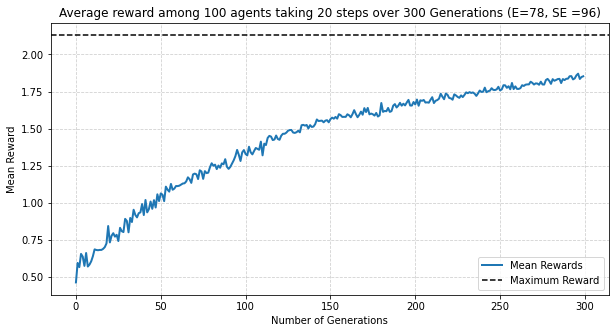

In [24]:
reward_elliptic_pairs = reward_function(2,5,8)
plt.figure(figsize=(10, 5))
plt.plot(mean_rewards, label="Mean Rewards", linewidth=2)
plt.axhline(y=reward_elliptic_pairs, color='black', label="Maximum Reward",linestyle='--')  # Vertical line at d = 1
#plt.plot(best_rewards, label="Second Reward", linestyle="dashed", linewidth=2, color="orange")
plt.xlabel("Number of Generations")
plt.ylabel("Mean Reward")
plt.title(f"Average reward among {number_agents_session:.0f} agents taking {max_number_steps:.0f} steps over {n_generations:.0f} Generations (E={elite_percentile:.0f}, SE ={super_elite_percentage:.0f})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

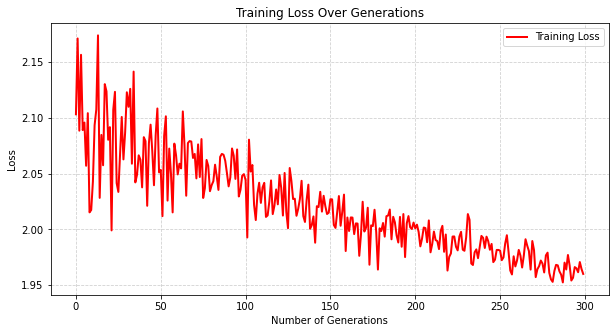

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss", linewidth=2, color="red")
plt.xlabel("Number of Generations")
plt.ylabel("Loss")
plt.title("Training Loss Over Generations")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [26]:
solutions

{(1, 7, 16), (1, 10, 16), (2, 5, 8)}

# **The following is the study of the reward function and the its execution times**

In [27]:
#cProfile.run('reward_function(2, 5, 8)')
start_time = time.time()
print( reward_function(2, 5, 8) )
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

2.1291005891761965
Elapsed time: 0.0803 seconds


In [28]:
#sample_number = 30
sampled_triples = set()

all_sample_times = []
all_sample_rewards = []
all_sample_area = []

bounded_times = []
bounded_rewards = []
bounded_area = []

#while (len(sampled_triples) < sample_number ) or ( len(bounded_times) < 100):
while len(bounded_times) < 10:
    a = random.randint(1, max_a)
    c = random.randint(1, max_c)
    b = random.randint(0, c)
    sampled_triples.add((a, b, c))  #Add directly the triple in a set.
    start_time = time.time()
    reward = reward_function(a,b,c)
    end_time = time.time()
    elapsed_time = round(end_time - start_time,4)
    all_sample_times.append(elapsed_time)
    all_sample_rewards.append(reward)
    all_sample_area.append( 1/2*a*c )
    if elapsed_time < 1:
      bounded_times.append(elapsed_time)
      bounded_rewards.append(reward)
      bounded_area.append( 1/2*a*c )

print( len(sampled_triples), len(all_sample_times), len(bounded_times) )

11 11 10


In [29]:
all_times_array  = np.array(all_sample_times)
all_rewards_array = np.array(all_sample_rewards)
all_area_array  = np.array(all_sample_area)

bounded_times_array  = np.array(bounded_times)
bounded_rewards_array = np.array(bounded_rewards)
bounded_area_array  = np.array(bounded_area)

# Calculate statistics
mean_all_time = np.mean(all_times_array)
max_all_time = np.max(all_times_array)
min_all_time = np.min(all_times_array)
median_all_time = np.median(all_times_array)

mean_bounded_time = np.mean(bounded_times_array)
max_bounded_time = np.max(bounded_times_array)
min_bounded_time = np.min(bounded_times_array)
median_bounded_time = np.median(bounded_times_array)

all_mean_reward = np.mean(all_rewards_array)
all_max_reward = np.max(all_rewards_array)
all_min_reward = np.min(all_rewards_array)

bounded_mean_reward = np.mean(bounded_rewards_array)
bounded_max_reward = np.max(bounded_rewards_array)
bounded_min_reward = np.min(bounded_rewards_array)

all_mean_area = np.mean(all_area_array)
all_max_area = np.max(all_area_array)
all_min_area = np.min(all_area_array)

In [30]:
np.std(bounded_times_array)

0.23450208719753435

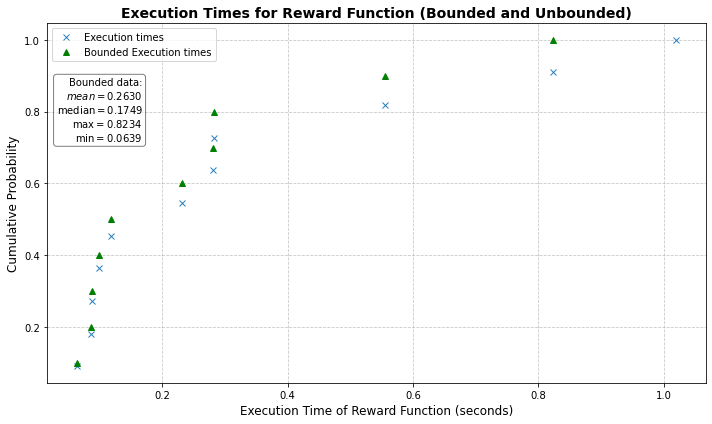

In [31]:
plt.figure(figsize=(10, 6))

# Plot for times_array
sorted_times = np.sort(all_times_array)
y_values = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
plt.plot(sorted_times, y_values, color="#2980b9", linestyle="None", marker="x", label="Execution times")

# Plot for bounded_times_array
sorted_bounded_times = np.sort(bounded_times_array)
y_bounded_values = np.arange(1, len(sorted_bounded_times) + 1) / len(sorted_bounded_times)
plt.plot(sorted_bounded_times, y_bounded_values, color="green", linestyle="None", marker="^", label="Bounded Execution times")

plt.xlabel("Execution Time of Reward Function (seconds)", fontsize=12)
plt.ylabel("Cumulative Probability", fontsize=12)
plt.title("Execution Times for Reward Function (Bounded and Unbounded)", fontsize=14, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.7)

# Text for bounded_times_array statistics
textstr_bounded = '\n'.join((
    r'Bounded data:',
    r'$ mean = %.4f$' % (mean_bounded_time,),
    r'$\mathrm{median}=%.4f$' % (median_bounded_time,),
    r'$\max=%.4f$' % (max_bounded_time,),
    r'$\min=%.4f$' % (min_bounded_time,)))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Place both text boxes on the plot
#plt.text(0.145, 0.85, textstr, transform=plt.gca().transAxes, fontsize=10,
#         verticalalignment='top', bbox=props, ha='right')
plt.text(0.145, 0.85, textstr_bounded, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props, ha='right')

plt.legend()
plt.tight_layout()
plt.show()

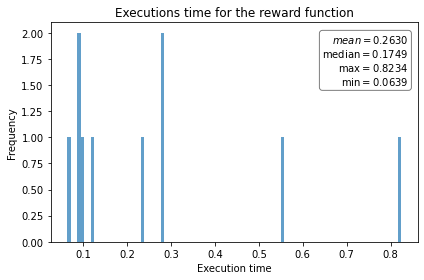

In [32]:
# Create the histogram

plt.hist(bounded_times_array, bins=100, alpha=0.7, label='Execution')

# Text for bounded_times_array statistics
textstr_bounded = '\n'.join((
    r'$ mean = %.4f$' % (mean_bounded_time,),
    r'$\mathrm{median}=%.4f$' % (median_bounded_time,),
    r'$\max=%.4f$' % (max_bounded_time,),
    r'$\min=%.4f$' % (min_bounded_time,)))


props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Place both text boxes on the plot
plt.text(0.975, 0.95, textstr_bounded, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props, ha='right')

#plt.legend()
# Customize the plot
plt.xlabel("Execution time")
plt.ylabel("Frequency")
plt.title("Executions time for the reward function")

plt.tight_layout()
plt.show()



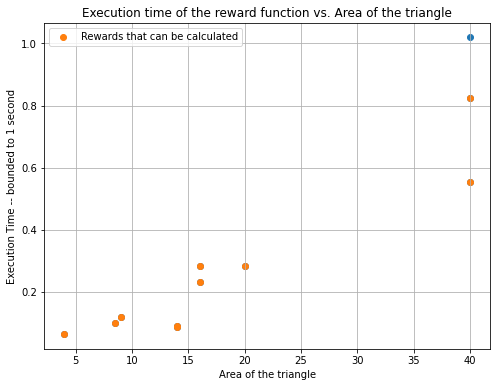

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(all_area_array, all_times_array)
plt.scatter(bounded_area_array, bounded_times_array, label = "Rewards that can be calculated")
plt.xlabel("Area of the triangle")
plt.ylabel("Execution Time -- bounded to 1 second")
plt.title("Execution time of the reward function vs. Area of the triangle")
plt.grid(True)
plt.legend()
plt.show()

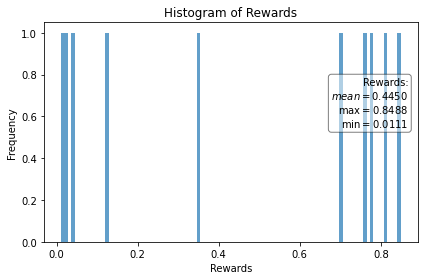

In [34]:
# Create the histogram

plt.hist(bounded_rewards_array, bins=100, alpha=0.7, label='Bounded Rewards')  # Adjust the number of bins as needed
# Text for reward statistics
textstr_rewards = '\n'.join((
    r'Rewards:',
#    r'$ mean (all)= %.4f$' % (mean_reward,),
#    r'$\max (all) = %.4f$' % (max_reward,),
#    r'$\min (all) = %.4f$' % (min_reward,),
    r'$ mean = %.4f$' % (bounded_mean_reward,),
    r'$\max = %.4f$' % (bounded_max_reward,),
    r'$\min = %.4f$' % (bounded_min_reward,)
    ))


props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Place both text boxes on the plot
plt.text(0.975, 0.75, textstr_rewards, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props, ha='right')

#plt.legend()
# Customize the plot
plt.xlabel("Rewards")
plt.ylabel("Frequency")
plt.title("Histogram of Rewards")

plt.tight_layout()
plt.show()